# Model quantization investigations

[quantization.py](quantization.py) provides a few functions used in this notebook.

In [22]:
from quantization import get_array_size_in_bytes, dequantize_weights, dequantize_weights_per_layer
from model_quantization import load_model, quantize_model_per_layer
import torch
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
exp = 201 # Pick up a model to quantize
model = load_model(exp)

Using augmentations ['h_roll', 'flip']
TOTAL ELEMENTS 7211
TOTAL ELEMENTS 2463
Got NaN in image /Data/geosciences/TP_5/data/validation/images/well_15_patch_201.npy
Got NaN in image /Data/geosciences/TP_5/data/validation/images/well_15_patch_202.npy


In [23]:
params = torch.cat([p.flatten() for p in model.parameters() if p.requires_grad])
params = params.detach().cpu().numpy()
print(len(params), "=", model.count_parameters(), "->", get_array_size_in_bytes(params), "Bytes")
quantized_weights, quantization_parameters = quantize_model_per_layer(model, num_bits=8)


7.26 Mb
1904135 = 1904135 -> 7616540 Bytes
1.81 Mb
7.26 Mb
compression ratio = 4.004


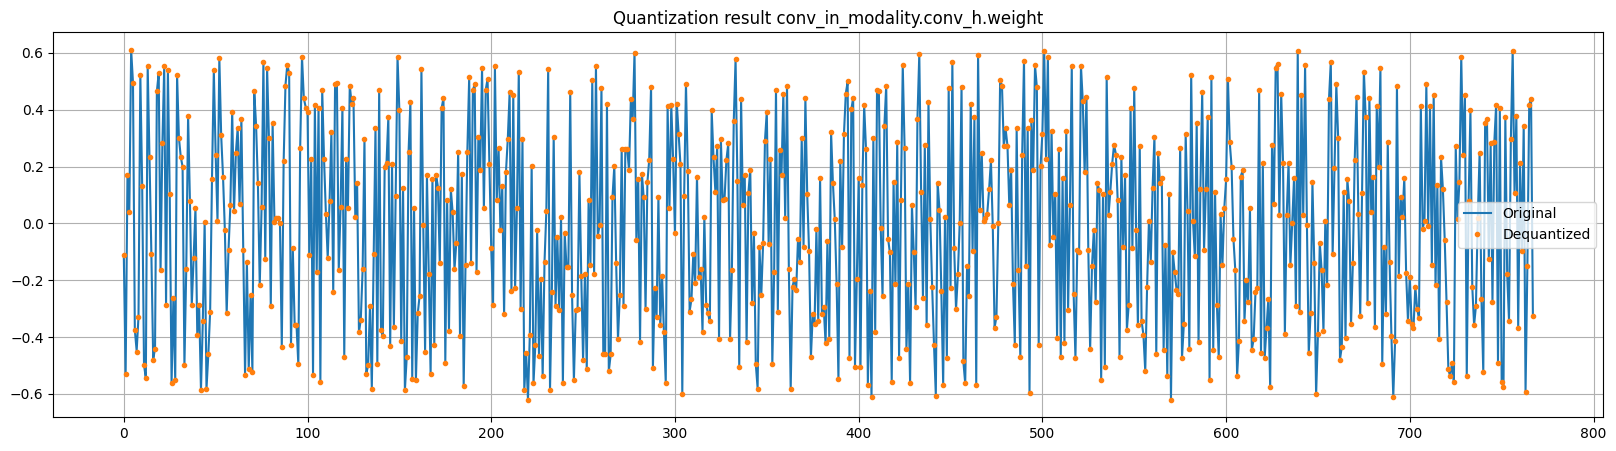

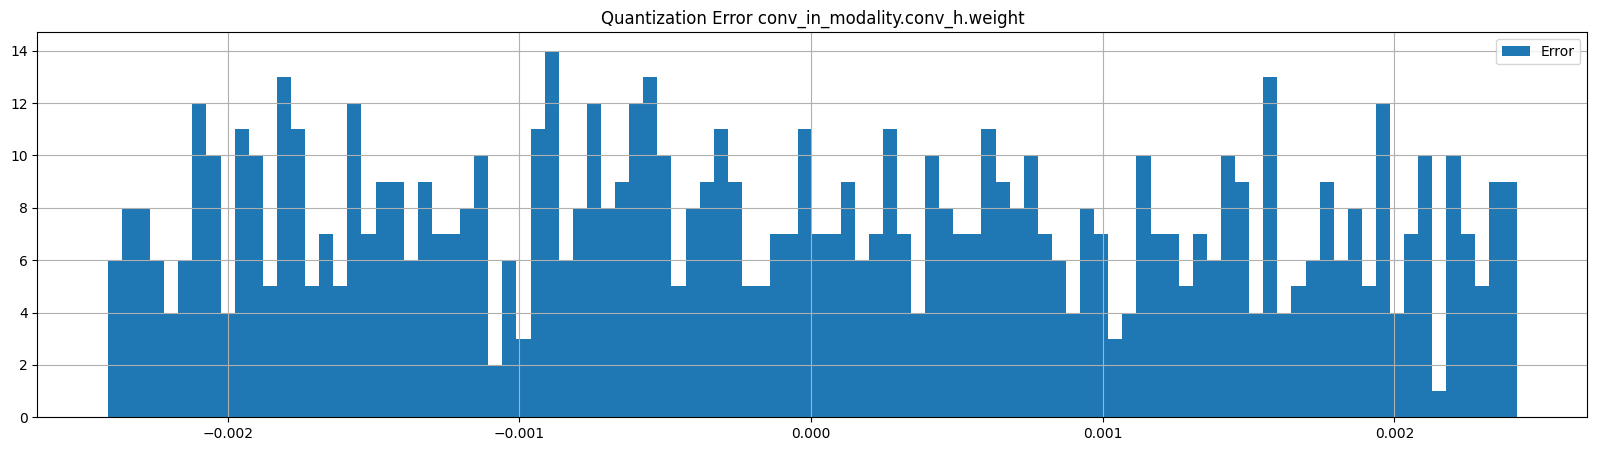

In [45]:
params_dequant = dequantize_weights_per_layer(quantized_weights, quantization_parameters)
layer_key= "conv_in_modality.conv_h.weight"
model_params_dict = dict(model.named_parameters())
params_no_qant = model_params_dict[layer_key].flatten().detach().cpu().numpy()
plt.figure(figsize=(20,5))
plt.plot(params_no_qant, label="Original")
plt.plot(params_dequant[layer_key].flatten(), ".", label="Dequantized")
plt.legend()
plt.grid()
plt.title(f"Quantization result {layer_key}")
plt.show()
plt.figure(figsize=(20,5))
plt.hist(params_no_qant-params_dequant[layer_key].flatten(), bins=100, label="Error")
plt.legend()
plt.title(f"Quantization Error {layer_key}")
plt.grid()
plt.show()

# Global weights distribution

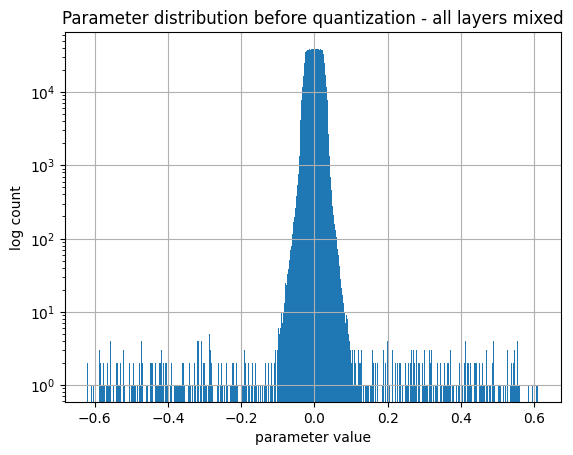

In [5]:
plt.hist(params, bins=1000)
plt.yscale('log')
plt.ylabel('log count')
plt.xlabel('parameter value')
plt.grid()
plt.title('Parameter distribution before quantization - all layers mixed')
plt.show()


# Need  for per-layer quantization
The following graph shows that if we perform global model quantization (same scaling for all weights, we will loose a lot of precision as each layer's weight have a slightly different dynamic).

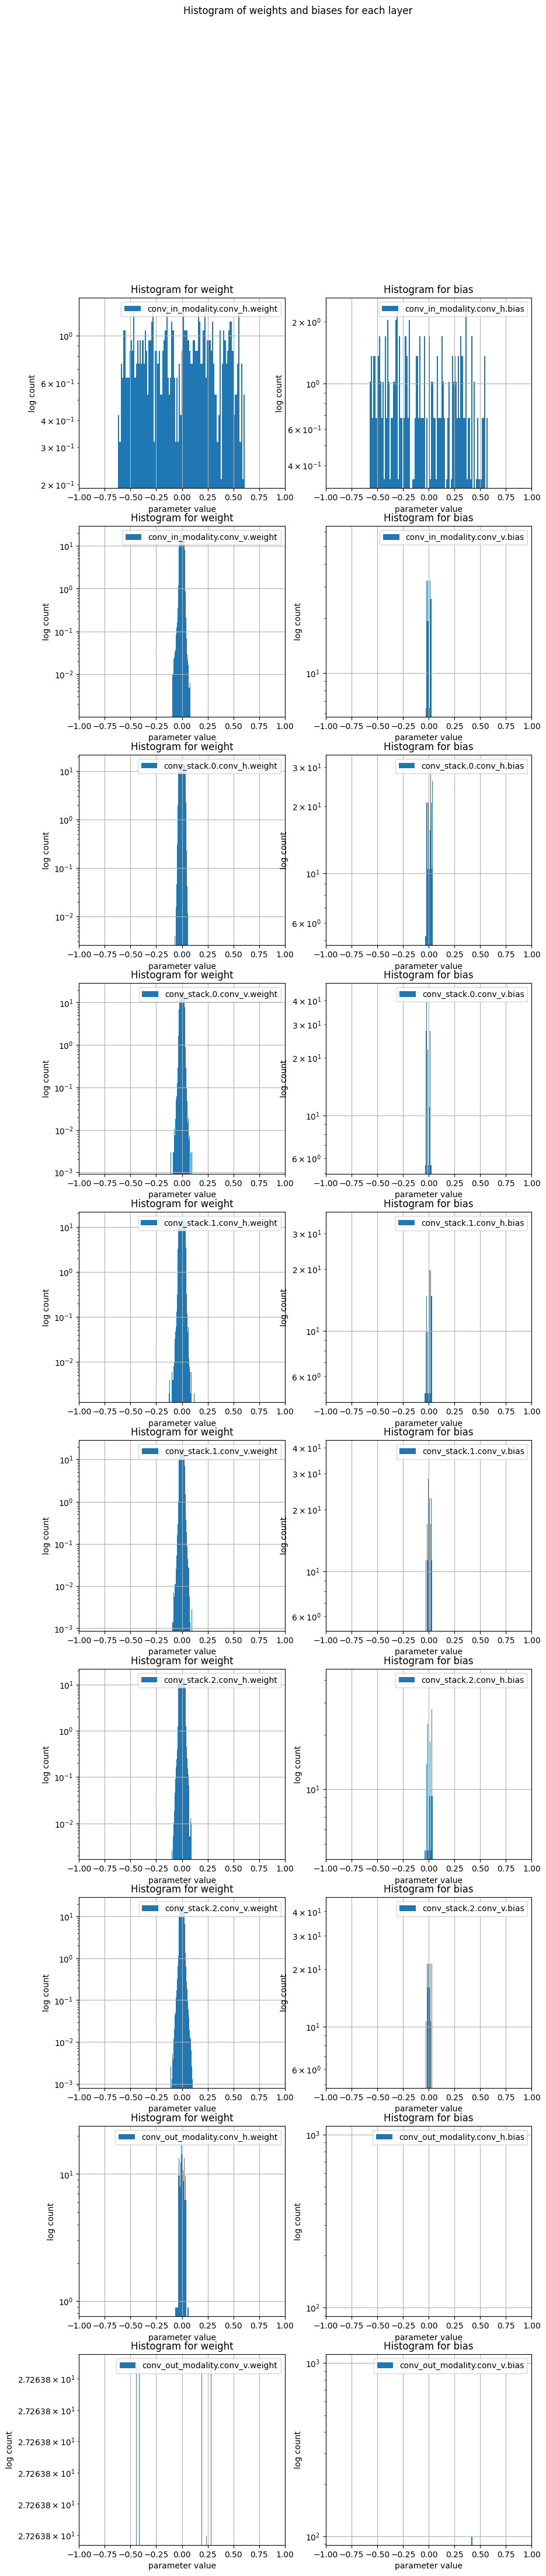

In [6]:
from matplotlib import pyplot as plt
tot = len([1 for _ in model.named_parameters()])
plt.figure(figsize=(10, tot//2*5))
for idx, (name, param) in enumerate(model.named_parameters()):
    if 'bias' not in name:
        plt.subplot(tot//2, 2, idx//2 * 2 + 1)
    else:
        plt.subplot(tot//2, 2, idx//2 * 2 + 2)
    if param.requires_grad:
        layer_params = param.detach().cpu().numpy().flatten()
        plt.hist(layer_params, bins=100, density=True, alpha=1, label=name)
        # plt.title(f'Histogram for Layer: {name}')
        plt.title('Histogram for weight' if 'weight' in name else 'Histogram for bias')
        plt.yscale('log')
        plt.ylabel('log count')
        plt.xlabel('parameter value')
        plt.legend()
        plt.xlim(-1., 1.)
        plt.grid()
plt.suptitle('Histogram of weights and biases for each layer')
plt.show()